In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, precision_recall_curve, precision_score, recall_score
from scipy.interpolate import interp1d
import matplotlib.patches as mpatches
from cycler import cycler
# import proplot
import math


In [2]:
plt.style.use(['science', "retro"])
# print(*list(plt.rcParams.keys()),sep="\n")
plt.rcParams.update({"axes.grid" : False})

In [3]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')

    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('Causal Parent Candidates')
    ax.set_ylabel("Masking Value")


def plot_violin(data_df, title, ground_truth, fname=None):

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
    ax.grid(False)
    ax.set_title(title)
    parts = ax.violinplot(
            data_df.to_numpy(),
            # quantiles=[[0.25, 0.75] for _ in data_df.columns],
            showmeans=False,
            showmedians=True,
            showextrema=True)
    labels = [f"${var.split('_')[0]}_" + "{" + f"{var.split('_')[1]}" + "}$" for var in data_df.columns]

    set_axis_style(ax, labels)

    violin_body_color = '#0087BD'
    violin_edge_color = 'white'
    violin_quantilelines_color = "#00416A"
    mean_color = "#ED872D"
    median_color = '#E30022'
    gt_color = "#228B22"
    edge_color = "black"

    whiskers_color_outline = "black"

    for pc in parts['bodies']:
        pc.set_facecolor(violin_body_color)
        pc.set_edgecolor(violin_edge_color)
        pc.set_alpha(0.4)

    quartile1, medians, quartile3 = np.percentile(data_df, [25, 50, 75], axis=0)

    mean = np.mean(data_df, axis=0)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip([np.sort(data_df[var]) for var in data_df], quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]


    inds = np.arange(1, len(medians) + 1)
    outline_lw = 0.5
    points_alpha = 1
    ax.scatter(inds,
           ground_truth,
           marker='o',
           color=gt_color,
           edgecolors=edge_color,
           linewidth=outline_lw,
           s=80,
           zorder=3,
           label="Ground Truth",
           alpha=points_alpha)
    # ax.scatter(inds,
    #            medians,
    #            marker='X',
    #            color=median_color,
    #            edgecolors=edge_color,
    #            linewidth=outline_lw,
    #            s=30,
    #            zorder=3,
    #            label="Median",
    #            alpha=points_alpha)

    ax.scatter(inds,
               mean,
               marker='o',
               color=mean_color,
               edgecolors=edge_color,
               linewidth=outline_lw,
               s=40,
               zorder=3,
               label="Mean",
               alpha=points_alpha)

    whiskers_alpha = 1
    # ax.vlines(inds, whiskersMin, quartile1, color=whiskers_color_outline, linestyle='-', lw=1.5, linestyles="dashed", alpha=whiskers_alpha)
    # ax.vlines(inds, quartile3, whiskersMax, color=violin_quantilelines_color, linestyle='-', lw=1, linestyles="dashed", alpha=whiskers_alpha)
    # ax.vlines(inds, quartile1, quartile3, color=whiskers_color_outline, linestyle='-', lw=4, linestyles="dashed", alpha=whiskers_alpha)
    ax.vlines(inds, quartile1, quartile3, color=violin_quantilelines_color, linestyle='-', lw=3, linestyles="dashed", alpha=whiskers_alpha)
    lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=True)
    # set style for the axes


    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    if fname is not None:
        if not os.path.isdir("plots"):
            os.mkdir("plots")
        plt.savefig(f"plots/{fname}.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [4]:
vars = ["X_0", "X_1", "X_2", "X_3", "X_4", "X_5", "X_6", "X_7", "X_8"]
vars_confounded = ["X_0", "X_1", "X_2", "X_3", "X_4", "X_5", "X_6", "X_7", "X_8", "X_10"]
ground_truth = [0, 1, 1, 1, 0, 0, 0, 0, 0]
ground_truth_confounded = [0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
# ground_truth = [0, 1, 1, 1, 1, 0, 1, 0, 0]
# ground_truth_confounded = [0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
named_ground_truth = pd.Series({
    name: val
    for name, val in zip(vars_confounded, ground_truth)
})
named_ground_truth_confounded = pd.Series({
    name: val
    for name, val in zip(vars_confounded, ground_truth_confounded)
})
ground_truth_confounded_df = pd.concat([pd.Series(ground_truth_confounded).to_frame().T] * 30, ignore_index=True, axis=0)
ground_truth_confounded_df.columns = vars_confounded
ground_truth_df = pd.concat([pd.Series(ground_truth).to_frame().T] * 30, ignore_index=True, axis=0)
ground_truth_df.columns = vars


In [5]:
experiment = 0
experiments = {k: v for k, v in zip(range(5), ["confounder", "noise", "nonlinear", "interventions", "samples"])}
results_single = dict()
results_multi = dict()
results_density = dict()
results_icp = dict()
results_pc = dict()
results_gies = dict()

res_folder = "/home/michael/Downloads/thesis_stuff/results_concat"
print(os.getcwd())
for filename in sorted(os.listdir(res_folder)):
    print(filename)
    if "density" in filename:
        results_density[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    elif "multi" in filename:
        results_multi[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    elif "single" in filename:
        results_single[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    elif "icp" in filename:
        results_icp[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    elif "pc" in filename:
        results_pc[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    elif "gies" in filename:
        results_gies[os.path.splitext(filename)[0]] = pd.read_csv(os.path.join(res_folder, filename), index_col=None)
    else:
        print("DOESNT BELONG TO ANY MODEL")


/home/michael/GitHub/CausalPy/examples
density_confoundertest_scenario-1.csv
density_confoundertest_scenario-2.csv
density_confoundertest_scenario-3.csv
density_interventionstest_scenario-do_reach-children_step-1.csv
density_interventionstest_scenario-do_reach-children_step-10.csv
density_interventionstest_scenario-do_reach-children_step-11.csv
density_interventionstest_scenario-do_reach-children_step-2.csv
density_interventionstest_scenario-do_reach-children_step-3.csv
density_interventionstest_scenario-do_reach-children_step-4.csv
density_interventionstest_scenario-do_reach-children_step-5.csv
density_interventionstest_scenario-do_reach-children_step-6.csv
density_interventionstest_scenario-do_reach-children_step-7.csv
density_interventionstest_scenario-do_reach-children_step-8.csv
density_interventionstest_scenario-do_reach-children_step-9.csv
density_interventionstest_scenario-do_reach-custom_step-1.csv
density_interventionstest_scenario-do_reach-custom_step-10.csv
density_interven

In [6]:
print(len(results_single))
print(len(results_multi))
print(len(results_density))
print(len(results_icp))
print(len(results_pc))
print(len(results_gies))

317
317
317
317
317
317


In [7]:
import re
exp_name_p = re.compile(r"[a-z]+(?=test)")
arg_p = re.compile(r"(?<=args-)[=\-\d.\w,]+(?=,source)")
dist_name_p = re.compile(r"(?<=dist-)[a-z]+")
scenario_p = re.compile(r"(?<=scenario-)[a-z\d\-]+")
step_p = re.compile(r"(?<=step-)[=\da-zA-Z,]+")

reach_p = re.compile(r"(?<=reach-)[a-zA-Z\-]+")

def name_for_noiseexp(fname):
    dist = re.search(dist_name_p, fname).group()
    args = re.search(arg_p, fname).group()
    return dist, args

def full_name_builder(name):
#     print(name)
    full_name = r"\textit{Experiment}: "
    model_name = name.split("_")[0]
    exp_name = re.search(exp_name_p, name).group().capitalize()
    full_name += exp_name
    dist, args, step = None, None, None
    scenario = re.search(scenario_p, name).group().capitalize()
    reach = re.search(reach_p, name)
    if reach is not None:
        reach = reach.group().capitalize()
        if reach == "Parents-and-children":
            reach = r"PA \& CH"
    full_name += r" - \textit{Scenario}: " + str(scenario)
    if "step" in name:
        step = re.search(step_p, name).group().capitalize()
        full_name += r" - \textit{Step}: " + str(step)
    if "noise" in name:
        dist, args = name_for_noiseexp(name)
        full_name += r" - \textit{Distribution}: " + str(dist.capitalize()) + f"({args.replace(',', ', ').replace('=', ' = ')})"

#     print(model_name, exp_name, scenario, step)
    return full_name, model_name, exp_name, scenario, dist, args, step, reach




We want to compute metrices of accuracy, precision, recall.
To do so the mask value outputs will be rounded to whole numbers by a different scheme:
 1. Any value greater than 0.5 is 1, less is 0, this allows accuracy, precision and recall metrics to be applied.
 2. Any value in [gt - \tau, gt + \tau] are seen as gt, otherwise 1 - gt
 (gt is the ground truth value, 1-gt thus simply means the wrong value).
 This shows the 'correct estimation rate' depending on the threshold \tau.
 What a correct estimation is, is decided by \tau.
 3. Change \tau to see the difference in the metric.

However, the first evaluation is the plotting of the run statistics. These will be violinplots over the results.

In [8]:
# x=3
# for i, (name, df) in enumerate(itertools.chain(
#     results_single.items(),
#     results_multi.items(),
#     results_density.items()
# )):
#     # if i > 1:
#     #     break
#     print(name)
#     gt = ground_truth
#     if "confounder" in name and "scenario-3" in name:
#         gt = ground_truth_confounded
#     plot_violin(df, full_name_builder(name)[0], gt, fname=name)

0.5 rule metrics

In [9]:
def comp_avg_metric(data, metric=accuracy_score, round_after=False):

    gt = ground_truth
    gt_df = ground_truth_df
    if len(data.columns) == 10:
        gt = ground_truth_confounded
        gt_df = ground_truth_confounded_df

    mean = data.mean(axis=0)
    quantiles = data.quantile([0.25, 0.5, 0.75], axis=0)

    if round_after:
        mean = mean.round()
        quantiles = quantiles.round()
#     print(quantiles)
    metric_mean = metric(gt, mean)
    metric_quantiles = dict()
    for name, quantile in quantiles.iterrows():
        metric_quantiles[name] = metric(gt, quantile)

    return {"mean": metric_mean, "quantiles": metric_quantiles}

def comp_metric_avg(data, metric=accuracy_score, round_after=False):
    avg = 0

    gt = named_ground_truth
    gt_df = ground_truth_df
    vals = []
    if len(data.columns) == 10:
        gt = named_ground_truth_confounded
        gt_df = ground_truth_confounded_df
    for i, row in data.iterrows():
#         print(row, gt)
        vals.append(pd.Series(metric(gt, row)))
    vals_df = pd.concat(vals)
    metric_mean = vals_df.mean(axis=0)
    metric_quantiles = vals_df.quantile([0.25, 0.5, 0.75])

    return {"mean": metric_mean, "quantiles": metric_quantiles}

In [10]:
# for i in range(1, 11):
#     df =results_icp["icp_noisetest_dist-cauchy_args-scale=" +str(i) + ",source=scipy_scenario-all_step-" + str(i)]
#     print("icp_noisetest_dist-cauchy_args-scale=" +str(i) + ",source=scipy_scenario-all_step-" + str(i))
#     print(df)
#     val = comp_metric_avg(df.round(), accuracy_score)
#     print(val)

Compute the values for every evaluation

In [11]:
def cer_but_n(df, gt_df, n):
    return ((rounded_df - ground_truth_df).abs().sum(axis=1) <= n).mean()


In [12]:

model_names = ["Single", "Multi", "Density"]
# model_names = ["Single", "Density"]
experiment_names = ["Interventions", "Nonlinearity", "Confounder", "Samplesize", "Noise"]
long_metric_names = {
    "acc-avg": "Accuracy",
    "avg-acc": r"$\overline{M}$ Accuracy",
    "prec-avg": "Precision-AVG",
    "rec-avg": "Recall",
    "aucpr-avg": "AUCPR",
    "avg-aucpr": r"$\overline{M}$ AUCPR"
}
metrics_names = ["acc-avg", "aucpr-avg", "avg-acc", "avg-aucpr"]
metric_to_func = {
    "acc-avg": accuracy_score,
    "avg-acc": accuracy_score,
    "prec": precision_score,
    "rec": recall_score,
    "aucpr-avg": average_precision_score,
    "avg-aucpr": average_precision_score
}
baseline_names = ["icp", "gies", "pc"]

In [13]:
metrics = {
    experiment: {} for experiment in experiment_names
}
icp_metrics = {
    experiment: {} for experiment in experiment_names
}
pc_metrics =  {
    experiment: {} for experiment in experiment_names
}
gies_metrics =  {
    experiment: {} for experiment in experiment_names
}

In [14]:
taus = [str(50)]
exp_results = list(itertools.chain(
        results_density.items(),
        results_single.items(),
        results_multi.items(),
))
nr_res = len(exp_results)
threshold_results = {n: {} for n, v in exp_results}


for name, df in itertools.chain(exp_results):
    _, model, exp_name, scenario_name, dist, args, step, reach = full_name_builder(name)
    model = model.capitalize()


    if exp_name == "Confounder":
        # exp - sce - model - metric -> VALUE
        if scenario_name not in metrics[exp_name]:
            metrics[exp_name][scenario_name] = {}

        if model not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][model] = {tau: {} for tau in taus}


    elif exp_name == "Noise":
        # exp - sce - dist - arg - model - metric -> VALUE

        if scenario_name not in metrics[exp_name]:
            metrics[exp_name][scenario_name] = {}

        if dist not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][dist] = {}

        if args not in metrics[exp_name][scenario_name][dist]:
            metrics[exp_name][scenario_name][dist][args] = {}

        if model not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][dist][args][model] = {tau: {} for tau in taus}

    elif exp_name == "Interventions":
        # exp - sce - reach - step - model - metric -> VALUE

        if scenario_name not in metrics[exp_name]:
            metrics[exp_name][scenario_name] = {}

        if reach not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][reach] = {}

        if step not in metrics[exp_name][scenario_name][reach]:
            metrics[exp_name][scenario_name][reach][step] = {}

        if model not in metrics[exp_name][scenario_name][reach][step]:
            metrics[exp_name][scenario_name][reach][step][model] = {tau: {} for tau in taus}


    else:
        # exp - sce - step - model - metric -> VALUE

        if scenario_name not in metrics[exp_name]:
            metrics[exp_name][scenario_name] = {}

        if step not in metrics[exp_name][scenario_name]:
            metrics[exp_name][scenario_name][step] = {}

        if model not in metrics[exp_name][scenario_name][step]:
            metrics[exp_name][scenario_name][step][model] = {tau: {} for tau in taus}


    for tau in taus:
        tau_float = int(tau) / 100
        rounded_df = pd.DataFrame(np.ones_like(df.to_numpy(), dtype=int), columns=df.columns)
        rounded_df[df < tau_float] = 0
#         for var in df:
#             gt = named_ground_truth[var]
#             if gt == 0:
#                 rounded_df.loc[(df.loc[:, var] < gt + tau_float) | (df.loc[:, var] == 0), var] = 0
#             else:
#                 rounded_df.loc[(df.loc[:, var] < gt - tau_float) | (df.loc[:, var] == 0), var] = 0
        threshold_results[name][tau] = rounded_df

        eval_func = None
        data_df = df
        round_after = False


        target_dict = None

        if exp_name == "Confounder":
            target_dict = metrics[exp_name][scenario_name][model][tau]

        elif exp_name == "Noise":
            target_dict = metrics[exp_name][scenario_name][dist][args][model][tau]

        elif exp_name == "Interventions":
            target_dict = metrics[exp_name][scenario_name][reach][step][model][tau]

        else:
            target_dict = metrics[exp_name][scenario_name][step][model][tau]

        for metric in metrics_names:

            if "-avg" in metric:
                eval_func = comp_metric_avg
                if "acc" in metric:
                    data_df = rounded_df
            elif "avg-" in metric:
                eval_func = comp_avg_metric
                if "acc" in metric:
                    round_after = True

            target_dict[metric] = eval_func(data_df, metric_to_func[metric], round_after=round_after)

In [15]:
# zero_baseline = {}
# zeros = pd.DataFrame(np.zeros_like(df), columns=df.columns)
# for i, metric in enumerate(metrics_names):
#     zero_baseline[metric] = comp_avg_metric(zeros, metric_to_func[metric])

In [16]:
metrics["Interventions"]["Do"]["Children"]["1"]["Density"]["50"]["acc-avg"]["quantiles"][0.25]

0.5555555555555556

In [17]:
# print(named_ground_truth)
# ref_confounded = pd.DataFrame.from_dict([named_ground_truth])
# print(ref)
# precision_score(results_icp[list(results_icp.keys())[0]].loc[0], .loc[0])


taus = [str(50)]
exp_results = list(itertools.chain(
        results_icp.items(),
        results_pc.items(),
        results_gies.items()
))
nr_res = len(exp_results)

baselines = {"Icp": icp_metrics, "Pc": pc_metrics, "Gies": gies_metrics}

for name, df in itertools.chain(exp_results):
    _, model, exp_name, scenario_name, dist, args, step, reach = full_name_builder(name)
    model = model.capitalize()

    curr_metrics = baselines[model]

    if exp_name == "Confounder":
        # exp - sce - model - metric -> VALUE
        if scenario_name not in curr_metrics[exp_name]:
            curr_metrics[exp_name][scenario_name] = {}

        if model not in curr_metrics[exp_name][scenario_name]:
            curr_metrics[exp_name][scenario_name][model] = {tau: {} for tau in taus}

    elif exp_name == "Noise":
        # exp - sce - dist - arg - model - metric -> VALUE

        if scenario_name not in curr_metrics[exp_name]:
            curr_metrics[exp_name][scenario_name] = {}

        if dist not in curr_metrics[exp_name][scenario_name]:
            curr_metrics[exp_name][scenario_name][dist] = {}

        if args not in curr_metrics[exp_name][scenario_name][dist]:
            curr_metrics[exp_name][scenario_name][dist][args] = {}

        if model not in curr_metrics[exp_name][scenario_name]:
            curr_metrics[exp_name][scenario_name][dist][args][model] = {tau: {} for tau in taus}


    elif exp_name == "Interventions":
        # exp - sce - reach - step - model - metric -> VALUE

        if scenario_name not in curr_metrics[exp_name]:
            curr_metrics[exp_name][scenario_name] = {}

        if reach not in curr_metrics[exp_name][scenario_name]:
            curr_metrics[exp_name][scenario_name][reach] = {}

        if step not in curr_metrics[exp_name][scenario_name][reach]:
            curr_metrics[exp_name][scenario_name][reach][step] = {}

        if model not in curr_metrics[exp_name][scenario_name][reach][step]:
            curr_metrics[exp_name][scenario_name][reach][step][model] = {tau: {} for tau in taus}

    else:
        # exp - sce - step - model - metric -> VALUE

        if scenario_name not in curr_metrics[exp_name]:
            curr_metrics[exp_name][scenario_name] = {}

        if step not in curr_metrics[exp_name][scenario_name]:
            curr_metrics[exp_name][scenario_name][step] = {}

        if model not in curr_metrics[exp_name][scenario_name][step]:
            curr_metrics[exp_name][scenario_name][step][model] = {tau: {} for tau in taus}

    for tau in taus:
#         tau_float = int(tau) / 100
#         rounded_df = pd.DataFrame(np.ones_like(df.to_numpy(), dtype=int), columns=df.columns)
#         rounded_df[df < tau_float] = 0

        target_dict = None

        if exp_name == "Confounder":
            target_dict = curr_metrics[exp_name][scenario_name][model][tau]

        elif exp_name == "Noise":
            target_dict = curr_metrics[exp_name][scenario_name][dist][args][model][tau]

        elif exp_name == "Interventions":
            target_dict = curr_metrics[exp_name][scenario_name][reach][step][model][tau]

        else:
            target_dict = curr_metrics[exp_name][scenario_name][step][model][tau]


        for metric in metrics_names:

            data_df = df
            if "-avg" in metric:
                eval_func = comp_metric_avg
                if "acc" in metric:
                    data_df = df.round()
            elif "avg-" in metric:
                eval_func = comp_avg_metric
                if "acc" in metric:
                    round_after = True

            target_dict[metric] = eval_func(data_df, metric_to_func[metric], round_after=round_after)

#             if model == "Pc" and dist == "cauchy":
#                 print(metric, eval_func, metric_to_func[metric])
#                 print(model, scenario, dist, args, step)
#                 print(data_df)
#                 print(eval_func(data_df, metric_to_func[metric], round_after=round_after))

In [18]:
def step_to_name(experiment, step_name):
    if experiment == "Samplesize":
        return str(2**(int(step_name)))
    elif experiment == "Interventions":
        return str((int(step_name)-1) / 2)
    else:
        return step_name

def cap(df):
    return np.max(
        [
            np.min(
                [
                    df,
                    np.ones_like(df)
                ],
                axis=0
            ),
            np.zeros_like(df)
        ],
        axis=0
    )


In [22]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)
# colors = [
#     ('#0087BD', "#7BDBFF", "#00516F"), # blue
#     ('#ED872D', "#FFBE85", "#9E4B00"), # orange
#     ('#006B3C', "#449F78", "#00351E"), # green
#     ('#E30022',"#F45972", "#8D0016"),  # red
#     ('#FFF600', "#FFF964", "#9B9500")  # yellow
# ]
models = model_names
colors = [f"#{c}" for c in ["076AB0", "CB152B", "058C42", "ED872D", "5C5C5C", "792359"]]
# colors = [f"#{c}" for c in ["D7495F", "ED872D", "5DD75B", "0087BD", "2FC5EA", "D4D758"]]
colors_by_model = {model: colors[i] for (i, model) in enumerate(model_names)}
colors_by_model.update({model.upper(): colors[i] for (i, model) in enumerate(baseline_names, len(model_names))})
# colors = [plt.get_cmap("viridis", 6)(i/6) for i in range(6)]
# colors = [proplot.Colormap("Phase")(i/6) for i in range(6)]
colors_by_model

figsize_h=(5.8,3/3*2)
figsize_v=(5.8,6/3*2)
ylim=(0,1.05)


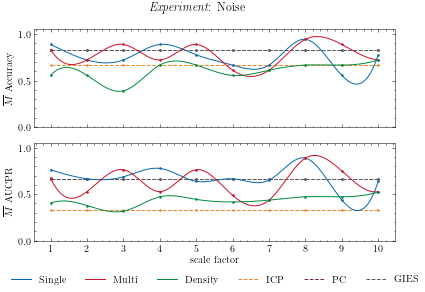

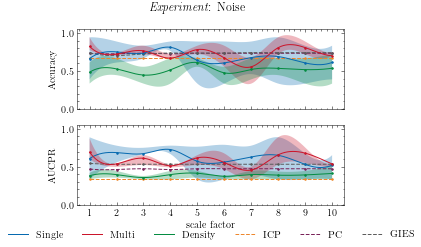

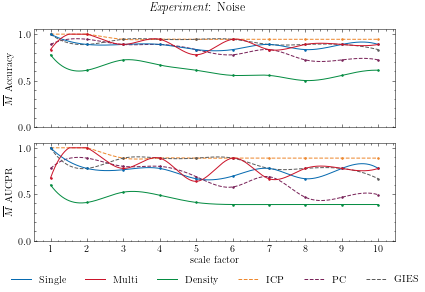

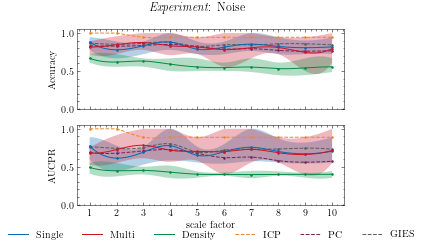

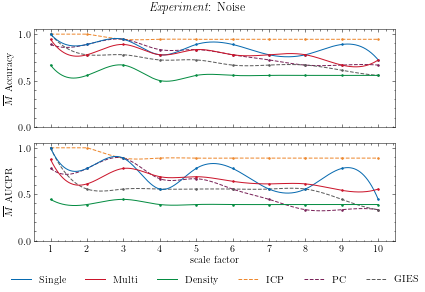

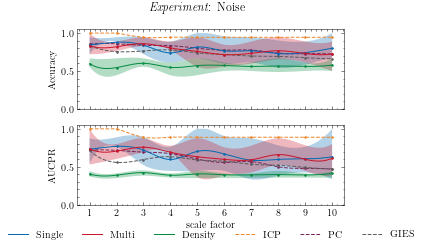

In [27]:
exp = "Noise"
distributions = {
    "normal": (r"$\mathcal{N}(0, \sigma^2)$", r"scale factor"),
    "exponential": (r"Exp$(\beta)$", r"scale factor"),
    "cauchy": ("Cauchy$(0, \gamma)$", "scale factor")
}
scenarios = list(metrics[exp].keys())
dists = list(metrics[exp][scenarios[0]].keys())

# colors = [proplot.Colormap("Phase")(i/6) for i in range(6)]
scenario = scenarios[0]

for dist in dists:

    fig, axes = plt.subplots(2, 1, figsize=figsize_v, sharex=True, sharey=True)
    fig2, axes2 = plt.subplots(2, 1, figsize=figsize_v, sharex=True, sharey=True)
    figs = [fig, fig2]
    all_axes = [axes, axes2]
    big = fig.add_subplot(111, frameon=False)
    big.grid(False)
    big.set_axis_off()
    big2 = fig2.add_subplot(111, frameon=False)
    big2.grid(False)
    big2.set_axis_off()
    bigs = [big, big2]
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    for i_met, metric in enumerate(metrics_names):
        if "acc" in metric:
            row = 0
        else:
            row = 1
        if "avg-" in metric:
            axes_arr = all_axes[0]
        else:
            axes_arr = all_axes[1]
        ax = axes_arr[row]
        for tau in taus:

            models = model_names
            data = {}

            for model in models:


                data[model] = {
                    arg: [metrics[exp][scenario][dist][arg][model][tau][metric] for scenario in scenarios]
                    for arg in metrics[exp][scenario][dist].keys()
                }
            icp = {
                arg: [icp_metrics[exp][scenario][dist][arg]["Icp"][tau][metric] for scenario in scenarios]
                for arg in icp_metrics[exp][scenario][dist].keys()
            }
            pc = {
                arg: [pc_metrics[exp][scenario][dist][arg]["Pc"][tau][metric] for scenario in scenarios]
                for arg in pc_metrics[exp][scenario][dist].keys()
            }
            gies = {
                arg: [gies_metrics[exp][scenario][dist][arg]["Gies"][tau][metric] for scenario in scenarios]
                for arg in gies_metrics[exp][scenario][dist].keys()
            }


            steps = np.array(
                [
                    int(v.split(",")[1].split("=")[1])
                    if "," in v
                    else int(v.split("=")[1])
                    for v in data[model].keys()
                ]
            )
            sort = np.argsort(steps)
            sorted_steps = np.array(steps)[sort]
            labels = steps[sort]
            accessors = np.array(list(data[model].keys()))[sort]

            x = np.arange(len([int(label) for label in labels]))

#                 horiz_line = ax.axhline(y=1, color='grey', linestyle='--')
            if "avg-" not in metric:
                for i, model in enumerate(models):
                    means = np.array([np.mean([data[model][step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])
                    quantile_25 = np.array([np.mean([data[model][step][i]["quantiles"][0.25] for i in range(len(scenarios))]) for step in accessors])
                    quantile_50 = np.array([np.mean([data[model][step][i]["quantiles"][0.50] for i in range(len(scenarios))])for step in accessors])
                    quantile_75 = np.array([np.mean([data[model][step][i]["quantiles"][0.75] for i in range(len(scenarios))])for step in accessors])

                    xnew = np.linspace(np.min(x), np.max(x), 1000, endpoint=True)
                    means_interp = interp1d(x, means, "cubic")(xnew)
                    quantile_25_interp = interp1d(x, quantile_25, "cubic")(xnew)
                    quantile_50_interp = interp1d(x, quantile_50, "cubic")(xnew)
                    quantile_75_interp = interp1d(x, quantile_75, "cubic")(xnew)

                    color = colors_by_model[model]

                    ax.fill_between(
                        xnew,
                        cap(quantile_25_interp),
                        cap(quantile_75_interp),
                        alpha=0.3,
                        facecolor=color
                    )

#                         ax.plot(
#                             xnew,
#                             cap(quantile_50_interp),
#                             "-",
#                             color=color,
# #                             path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
#                             lw=0.5,
#                             alpha=0.7,
#                         )

            for label, datapack in zip(["ICP", "PC", "GIES"], [icp, pc, gies]):
                if True:
                    means = np.array([np.mean([datapack[step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])
#                         print(means)
#                         stds = np.array([datapack[step]["std"] for step in accessors])


                    xnew = np.linspace(np.min(x), np.max(x), 100, endpoint=True)
                    means_interp = interp1d(x, means, "cubic")(xnew)
#                         stds_interp = interp1d(x, stds, "cubic")(xnew)

                    color = colors_by_model[label.upper()]

                    ax.plot(
                        xnew,
                        cap(means_interp),
                        "--",
#                             path_effects=[pe.Stroke(linewidth=2.5, foreground='black', alpha=.2), pe.Normal()],
                        color=color,
                        label=label,
                        lw=1,
                        alpha=1,
                    )
                    ax.plot(
                        x,
                        cap(means),
                        "o",
                        color=color,
#                             path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
                        markersize=1.5,
                        lw=.1,
                        alpha=1,
                    )
#                     ax.fill_between(
#                         xnew,
#                         cap(means_interp-stds_interp),
#                         cap(means_interp+stds_interp),
#                         alpha=0.2,
#                         facecolor=colors[j]
#                     )

            for i, model in enumerate(models):
                means = np.array([np.mean([data[model][step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])
                quantile_25 = np.array([np.mean([data[model][step][i]["quantiles"][0.25] for i in range(len(scenarios))]) for step in accessors])
                quantile_50 = np.array([np.mean([data[model][step][i]["quantiles"][0.50] for i in range(len(scenarios))]) for step in accessors])
                quantile_75 = np.array([np.mean([data[model][step][i]["quantiles"][0.75] for i in range(len(scenarios))]) for step in accessors])

                xnew = np.linspace(np.min(x), np.max(x), 1000, endpoint=True)
                means_interp = interp1d(x, means, "cubic")(xnew)
                quantile_25_interp = interp1d(x, quantile_25, "cubic")(xnew)
                quantile_50_interp = interp1d(x, quantile_50, "cubic")(xnew)
                quantile_75_interp = interp1d(x, quantile_75, "cubic")(xnew)

                color = colors_by_model[model]

                ax.plot(
                    xnew,
                    cap(means_interp),
                    "-",
                    color=color,
#                         path_effects=[pe.Stroke(linewidth=2.5, foreground='black', alpha=.2), pe.Normal()],
                    label=model,
                    lw=1,
                    alpha=1,
                )
                ax.plot(
                    x,
                    cap(means),
                    "o",
                    markersize=1.5,
                    color=color,
#                         path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
                    lw=.1,
                    alpha=1,
                )


#                 if zero_baseline[metric]["mean"] > 0:
#                     ax.axhline(y=zero_baseline[metric]["mean"], color=colors[i][2], linestyle='--', label=f"Zero-Estimate {long_metric_names[metric]}", zorder=0)

#                     if style in [0, 2]:

            ax.set_ylabel(long_metric_names[metric])
            if row ==1:
                ax.set_xlabel(distributions[dist][1])
            ax.set_ylim(*ylim)
            ax.set_xticks(x)
            ax.set_xticklabels(labels)

        handles, labels = ax.get_legend_handles_labels()
        handles = handles[3:] + handles[:3]
        labels = labels[3:] + labels[:3]

        fig.suptitle(r"\textit{Experiment}: " + exp)

        fig2.suptitle(r"\textit{Experiment}: " + exp)

        fig2.tight_layout(rect=[0, 0.03, 1, 1])
        fig.tight_layout(rect=[0, 0.03, 1, 1])

        if i_met % 2 == 1:
            bigs[i_met < 2].legend(handles,labels, loc='lower center', bbox_to_anchor = (0.5, -.25),
                                    ncol=6, fancybox=True, shadow=True)
            if "avg-" in metric:
                name = "estim"
            else:
                name = "metric"
            #$ PLOT ORDER ESSENTIAL OTHERWISE ONE IS SIMPLY EMPTY (DUNNO WHY)
            figs[i_met <2].savefig(f"/home/michael/Downloads/thesis_stuff/nonsense/{exp}_{name}.pdf")
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/michael/Desktop/nonsense/Confounder_metric.pdf'

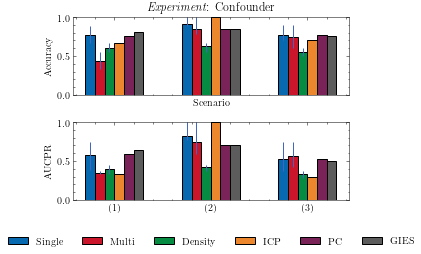

In [26]:
exp = "Confounder"
scenarios = list(metrics[exp].keys())


first = "-avg"

for i_met, metric in enumerate(metrics_names, 0):
    if i_met % 2 == 0:
        fig, axes = plt.subplots(2, 1, figsize=[figsize_v[0], figsize_v[1] * 1], sharex=True, sharey=True)
        big = fig.add_subplot(111, frameon=False)
        big.grid(False)

        # hide tick and tick label of the big axis
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big.set_axis_off()

        axes = (ax for ax in axes.flatten())

    ax = next(axes)
    for tau in taus:
        data = {}

        for model in model_names:
            data[model] = [metrics[exp][scenario][model][tau][metric] for scenario in scenarios]

        icp = [icp_metrics[exp][scenario]["Icp"][tau][metric] for scenario in scenarios]
        pc = [pc_metrics[exp][scenario]["Pc"][tau][metric] for scenario in scenarios]
        gies = [gies_metrics[exp][scenario]["Gies"][tau][metric] for scenario in scenarios]

        x = np.arange(len(scenarios))  # the label locations
        width = 0.1  # the width of the bars


        nr_bars = 6

        if nr_bars % 2 == 0:
            offset = nr_bars - 1
            div = 2
            dist = 2
        else:
            div = 1
            dist = 1
            offset = nr_bars // 2

        rects = []
        for i, model in enumerate(model_names):
            rects.append(
                ax.bar(
                    x + (i * dist - offset) * width / div,
                    cap([e["mean"] for e in data[model]]),
                    width,
                    color=colors_by_model[model],
#                     yerr=[e["std"] for e in data[model]],
                    label=model,
                    edgecolor="black",
                    capsize=5
                )
            )
            if "avg-" not in metric:
                ax.vlines(
                    x + (i * dist - offset) * width / div,
                    cap([e["quantiles"][0.25] for e in data[model]]),
                    cap([e["quantiles"][0.75] for e in data[model]])
                )

        for j, label, datapack in zip(range(i+1, i+1 + 3), ["ICP", "PC", "GIES"], [icp, pc, gies]):

            rects.append(
                ax.bar(
                    x + (j * dist - offset) * width / div,
                    cap([e["mean"] for e in datapack]),
                    width,
                    color=colors_by_model[label],
                    label=label,
                    edgecolor="black",
                    capsize=5
                )
            )

#         if zero_baseline[metric]["mean"] > 0:
#             ax.axhline(y=zero_baseline[metric]["mean"], color=colors[i][2], linestyle='--', lw=2, label=f"Zero-Estimate", zorder=0)
#         horiz_line = ax.axhline(y=1, color='grey', linestyle='--')
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(long_metric_names[metric])

        ax.set_ylim(0, 1.002)
        ax.set_xticks(x)
        ax.set_xticklabels([f"({s})" for s in scenarios])
        if i_met % 2 == 1:

            ax.set_xlabel('Scenario')

            big.legend(*ax.get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, -0.15),
              ncol=6, fancybox=True, shadow=True)
            plt.tight_layout()
            if "avg-" in metric:
                name = "estim"
            else:
                name = "metric"
            plt.savefig(f"/home/michael/Desktop/nonsense/{exp}_{name}.pdf")
            plt.show()

        else:

            ax.set_title(r"\textit{Experiment}: " + exp)




['Halflinear', 'Linear', 'Nonlinear']


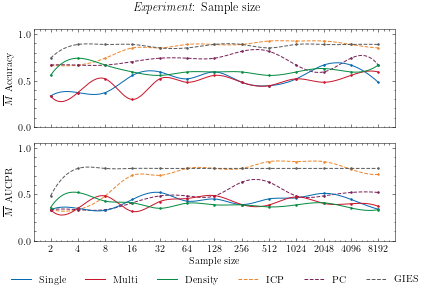

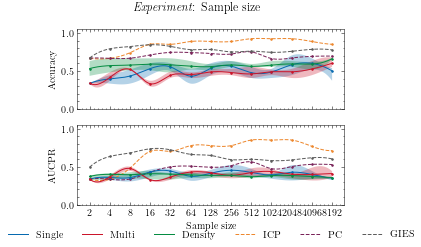

In [37]:
exp = "Samplesize"
scenarios = list(metrics[exp].keys())
print(scenarios)

fig, axes = plt.subplots(2, 1, figsize=figsize_v, sharex=True, sharey=True)
fig2, axes2 = plt.subplots(2, 1, figsize=figsize_v, sharex=True, sharey=True)
figs=[fig,fig2]
all_axes = [axes, axes2]
big = fig.add_subplot(111, frameon=False)
big.grid(False)
big.set_axis_off()
big2 = fig2.add_subplot(111, frameon=False)
big2.grid(False)
big2.set_axis_off()
bigs = [big, big2]
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

for i_met, metric in enumerate(metrics_names):
    if "acc" in metric:
        row = 0
    else:
        row = 1
    if "avg-" in metric:
        axes_arr = all_axes[0]
    else:
        axes_arr = all_axes[1]

    ax = axes_arr[row]
    for tau in taus:
        data = {}
        icp = {}
        pc = {}
        gies = {}
        steps = list(metrics[exp][scenarios[0]].keys())
        for model in model_names:
            data[model] = {
                step: [metrics[exp][scenario][step][model][tau][metric] for scenario in scenarios]
                for step in steps
            }
        icp = {
            step: [icp_metrics[exp][scenario][step]["Icp"][tau][metric] for scenario in scenarios]
            for step in steps
        }
        pc = {
            step: [pc_metrics[exp][scenario][step]["Pc"][tau][metric] for scenario in scenarios]
            for step in steps
        }
        gies = {
            step: [gies_metrics[exp][scenario][step]["Gies"][tau][metric] for scenario in scenarios]
            for step in steps
        }


        nr_lines = 6
        labels = np.array([int(step_to_name(exp, step)) for step in steps])
        sort = np.argsort(labels)
        labels = labels[sort]
        x = np.arange(len(labels))

        accessors = np.array(list(data[model].keys()))[sort]


        for label, datapack in zip(["ICP", "PC", "GIES"], [icp, pc, gies]):
            if True:
                means = np.array([np.mean([datapack[step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])


                xnew = np.linspace(np.min(x), np.max(x), 100, endpoint=True)
                means_interp = interp1d(x, means, "cubic")(xnew)

                color = colors_by_model[label.upper()]

                ax.plot(
                    xnew,
                    cap(means_interp),
                    "--",
#                             path_effects=[pe.Stroke(linewidth=2.5, foreground='black', alpha=.2), pe.Normal()],
                    color=color,
                    label=label,
                    lw=1,
                    alpha=1,
                )
                ax.plot(
                    x,
                    cap(means),
                    "o",
                    color=color,
#                             path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
                    markersize=1.5,
                    lw=.1,
                    alpha=1,
                )
#                     ax.fill_between(
#                         xnew,
#                         cap(means_interp-stds_interp),
#                         cap(means_interp+stds_interp),
#                         alpha=0.2,
#                         facecolor=colors[j]
#                     )

        if "avg-" not in metric:
            for _, model in enumerate(models):
                means = np.array([np.mean([data[model][step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])
                quantile_25 = np.array([np.mean([data[model][step][i]["quantiles"][0.25] for i in range(len(scenarios))]) for step in accessors])
                quantile_50 = np.array([np.mean([data[model][step][i]["quantiles"][0.50] for i in range(len(scenarios))]) for step in accessors])
                quantile_75 = np.array([np.mean([data[model][step][i]["quantiles"][0.75] for i in range(len(scenarios))]) for step in accessors])

                xnew = np.linspace(np.min(x), np.max(x), 1000, endpoint=True)
                means_interp = interp1d(x, means, "cubic")(xnew)
                quantile_25_interp = interp1d(x, quantile_25, "cubic")(xnew)
                quantile_50_interp = interp1d(x, quantile_50, "cubic")(xnew)
                quantile_75_interp = interp1d(x, quantile_75, "cubic")(xnew)

                color = colors_by_model[model]

                ax.fill_between(
                    xnew,
                    cap(quantile_25_interp),
                    cap(quantile_75_interp),
                    alpha=0.3,
                    facecolor=color
                )

#                         ax.plot(
#                             xnew,
#                             cap(quantile_50_interp),
#                             "-",
#                             color=color,
# #                             path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
#                             lw=0.5,
#                             alpha=0.7,
#                         )
        for _, model in enumerate(models):
            means = np.array([np.mean([data[model][step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])
            quantile_25 = np.array([np.mean([data[model][step][i]["quantiles"][0.25] for i in range(len(scenarios))]) for step in accessors])
            quantile_50 = np.array([np.mean([data[model][step][i]["quantiles"][0.50] for i in range(len(scenarios))]) for step in accessors])
            quantile_75 = np.array([np.mean([data[model][step][i]["quantiles"][0.75] for i in range(len(scenarios))]) for step in accessors])

            xnew = np.linspace(np.min(x), np.max(x), 1000, endpoint=True)
            means_interp = interp1d(x, means, "cubic")(xnew)
            quantile_25_interp = interp1d(x, quantile_25, "cubic")(xnew)
            quantile_50_interp = interp1d(x, quantile_50, "cubic")(xnew)
            quantile_75_interp = interp1d(x, quantile_75, "cubic")(xnew)

            color = colors_by_model[model]

            ax.plot(
                xnew,
                cap(means_interp),
                "-",
                color=color,
#                         path_effects=[pe.Stroke(linewidth=2.5, foreground='black', alpha=.2), pe.Normal()],
                label=model,
                lw=1,
                alpha=1,
            )
            ax.plot(
                x,
                cap(means),
                "o",
                markersize=1.5,
                color=color,
#                         path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
                lw=.1,
                alpha=1,
            )



#                     if style in [0, 2]:
#                 if i_r % 2 == 0:
        ax.set_ylabel(long_metric_names[metric])
#                     if style in [2, 3]:
        if i_met % 2:
            ax.set_xlabel("Sample size")

        ax.set_ylim(*ylim)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)


#                 plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
#                       ncol=3, fancybox=True, shadow=True)
#                 big.legend(handles, leg_labels, loc='lower center', bbox_to_anchor = (0.5, -.2),
#                       ncol=2, fancybox=True, shadow=True)
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[3:] + handles[:3]
    labels = labels[3:] + labels[:3]

    fig.suptitle(
        r"\textit{Experiment}: Sample size")


    fig2.suptitle(r"\textit{Experiment}: Sample size")

    fig2.tight_layout(rect=[0, 0.03, 1, 1])
    fig.tight_layout(rect=[0, 0.03, 1, 1])

    if i_met % 2 == 1:
        bigs[i_met < 2].legend(handles,labels, loc='lower center', bbox_to_anchor = (0.5, -.25),
                                ncol=6, fancybox=True, shadow=True)
        if "avg-" in metric:
            name = "estim"
        else:
            name = "metric"
        #$ PLOT ORDER ESSENTIAL OTHERWISE ONE IS SIMPLY EMPTY (DUNNO WHY)
        figs[i_met <2].savefig(f"/home/michael/Downloads/thesis_stuff/nonsense/{exp}_{name}.pdf")




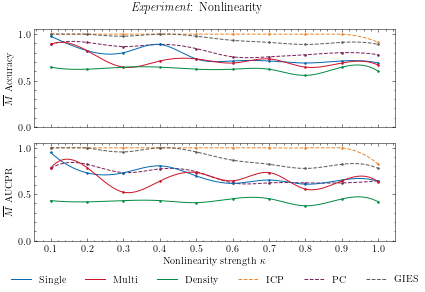

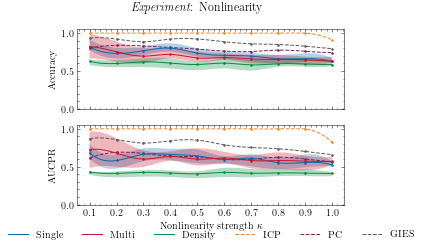

In [33]:
exp = "Nonlinearity"
scenarios = list(metrics[exp].keys())
scenario = scenarios[0]
fig, axes = plt.subplots(2, 1, figsize=figsize_v, sharex=True, sharey=True)
fig2, axes2 = plt.subplots(2, 1, figsize=figsize_v, sharex=True, sharey=True)
figs = [fig, fig2]
all_axes = [axes, axes2]
big = fig.add_subplot(111, frameon=False)
big.grid(False)
big.set_axis_off()
big2 = fig2.add_subplot(111, frameon=False)
big2.grid(False)
big2.set_axis_off()
bigs = [big, big2]
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

for i_met, metric in enumerate(metrics_names):
    if "acc" in metric:
        col = 0
    else:
        col = 1
    if "avg-" in metric:
        axes_arr = all_axes[0]
    else:
        axes_arr = all_axes[1]

    ax = axes_arr[i_met % 2]
    for tau in taus:
        data = {}
        for model in model_names:
            data[model] = {
                step: [metrics[exp][scenario][step][model][tau][metric] for scenario in scenarios]
                for step in metrics[exp][scenario].keys()
            }
        icp = {
            step: [icp_metrics[exp][scenario][step]["Icp"][tau][metric] for scenario in scenarios]
            for step in icp_metrics[exp][scenario].keys()
        }
        pc = {
            step: [pc_metrics[exp][scenario][step]["Pc"][tau][metric] for scenario in scenarios]
            for step in icp_metrics[exp][scenario].keys()
        }
        gies = {
            step: [gies_metrics[exp][scenario][step]["Gies"][tau][metric] for scenario in scenarios]
            for step in icp_metrics[exp][scenario].keys()
        }

        steps = [int(v) for v in data[model].keys()]
        sort = np.argsort(steps)
        sorted_steps = np.array(steps)[sort]
        labels = np.array([int(step_to_name(exp, step)) / np.max(steps) for step in data[model]])[sort]

        x = np.arange(len(labels))

        accessors = np.array(list(data[model].keys()))[sort]

        for label, datapack in zip(["ICP", "PC", "GIES"], [icp, pc, gies]):
            if True:
                means = np.array([np.mean([datapack[step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])


                xnew = np.linspace(np.min(x), np.max(x), 100, endpoint=True)
                means_interp = interp1d(x, means, "cubic")(xnew)

                color = colors_by_model[label.upper()]

                ax.plot(
                    xnew,
                    cap(means_interp),
                    "--",
#                             path_effects=[pe.Stroke(linewidth=2.5, foreground='black', alpha=.2), pe.Normal()],
                    color=color,
                    label=label,
                    lw=1,
                    alpha=1,
                )
                ax.plot(
                    x,
                    cap(means),
                    "o",
                    color=color,
#                             path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
                    markersize=1.5,
                    lw=.1,
                    alpha=1,
                )
#                     ax.fill_between(
#                         xnew,
#                         cap(means_interp-stds_interp),
#                         cap(means_interp+stds_interp),
#                         alpha=0.2,
#                         facecolor=colors[j]
#                     )

        if "avg-" not in metric:
            for i, model in enumerate(models):
                means = np.array([np.mean([data[model][step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])
                quantile_25 = np.array([np.mean([data[model][step][i]["quantiles"][0.25] for i in range(len(scenarios))]) for step in accessors])
                quantile_50 = np.array([np.mean([data[model][step][i]["quantiles"][0.50] for i in range(len(scenarios))]) for step in accessors])
                quantile_75 = np.array([np.mean([data[model][step][i]["quantiles"][0.75] for i in range(len(scenarios))]) for step in accessors])

                xnew = np.linspace(np.min(x), np.max(x), 1000, endpoint=True)
                means_interp = interp1d(x, means, "cubic")(xnew)
                quantile_25_interp = interp1d(x, quantile_25, "cubic")(xnew)
                quantile_50_interp = interp1d(x, quantile_50, "cubic")(xnew)
                quantile_75_interp = interp1d(x, quantile_75, "cubic")(xnew)

                color = colors_by_model[model]

                ax.fill_between(
                    xnew,
                    cap(quantile_25_interp),
                    cap(quantile_75_interp),
                    alpha=0.3,
                    facecolor=color
                )

#                         ax.plot(
#                             xnew,
#                             cap(quantile_50_interp),
#                             "-",
#                             color=color,
# #                             path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
#                             lw=0.5,
#                             alpha=0.7,
#                         )
        for i, model in enumerate(models):
            means = np.array([np.mean([data[model][step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])
            quantile_25 = np.array([np.mean([data[model][step][i]["quantiles"][0.25] for i in range(len(scenarios))]) for step in accessors])
            quantile_50 = np.array([np.mean([data[model][step][i]["quantiles"][0.50] for i in range(len(scenarios))]) for step in accessors])
            quantile_75 = np.array([np.mean([data[model][step][i]["quantiles"][0.75] for i in range(len(scenarios))]) for step in accessors])

            xnew = np.linspace(np.min(x), np.max(x), 1000, endpoint=True)
            means_interp = interp1d(x, means, "cubic")(xnew)
            quantile_25_interp = interp1d(x, quantile_25, "cubic")(xnew)
            quantile_50_interp = interp1d(x, quantile_50, "cubic")(xnew)
            quantile_75_interp = interp1d(x, quantile_75, "cubic")(xnew)

            color = colors_by_model[model]

            ax.plot(
                xnew,
                cap(means_interp),
                "-",
                color=color,
#                         path_effects=[pe.Stroke(linewidth=2.5, foreground='black', alpha=.2), pe.Normal()],
                label=model,
                lw=1,
                alpha=1,
            )
            ax.plot(
                x,
                cap(means),
                "o",
                markersize=1.5,
                color=color,
#                         path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
                lw=.1,
                alpha=1,
            )



#             ax.set_title(
#                 r"\textit{Experiment}: " + "e ".join(exp.split("e", 1)) +
#                 r"\quad \textit{Scenario}: " + title_scen
#             )

        ax.set_ylabel(long_metric_names[metric])
#                     if style in [2, 3]:
        if i_met % 2:
            ax.set_xlabel("Nonlinearity strength $\kappa$")

        ax.set_ylim(*ylim)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)


#                 plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
#                       ncol=3, fancybox=True, shadow=True)
#                 big.legend(handles, leg_labels, loc='lower center', bbox_to_anchor = (0.5, -.2),
#                       ncol=2, fancybox=True, shadow=True)
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[3:] + handles[:3]
    labels = labels[3:] + labels[:3]

    fig.suptitle(
        r"\textit{Experiment}: " + exp)


    fig2.suptitle(r"\textit{Experiment}: " + exp)

    fig2.tight_layout(rect=[0, 0.03, 1, 1])
    fig.tight_layout(rect=[0, 0.03, 1, 1])

    if i_met % 2 == 1:
        bigs[i_met < 2].legend(handles,labels, loc='lower center', bbox_to_anchor = (0.5, -.25),
                                ncol=6, fancybox=True, shadow=True)
        if "avg-" in metric:
            name = "estim"
        else:
            name = "metric"
        #$ PLOT ORDER ESSENTIAL OTHERWISE ONE IS SIMPLY EMPTY (DUNNO WHY)
        figs[i_met <2].savefig(f"/home/michael/Downloads/thesis_stuff/nonsense/{exp}_{name}.pdf")




In [ ]:
exp = "Interventions"
scenarios = list(metrics[exp].keys())
scenario = scenarios[0]
reachs = list(metrics[exp][scenarios[0]].keys())
# reachs.remove("Custom")
# reachs.remove('Parents-and-children')
# idx_pach = reachs.index("Parents-and-children")
# reachs[idx_pach] = "PA & CH"
reachs = [reachs[2], reachs[3], reachs[4], reachs[0]]
models = model_names

fig, axes = plt.subplots(2, 1, figsize=figsize_v, sharex=True, sharey=True)
fig2, axes2 = plt.subplots(2, 1, figsize=figsize_v, sharex=True, sharey=True)
figs = [fig, fig2]
all_axes = [axes, axes2]
big = fig.add_subplot(111, frameon=False)
big.grid(False)
big.set_axis_off()
big2 = fig2.add_subplot(111, frameon=False)
big2.grid(False)
big2.set_axis_off()
bigs = [big, big2]
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
reach = list(reachs)[0]
for i_met, metric in enumerate(metrics_names):
    if "acc" in metric:
        col = 0
    else:
        col = 1
    if "avg-" in metric:
        axes_arr = all_axes[0]
    else:
        axes_arr = all_axes[1]

    ax = axes_arr[i_met % 2]

    for tau in taus:
        data = {}
        for model in model_names:
            data[model] = {
                step: [metrics[exp][scenario][reach][step][model][tau][metric] for scenario in scenarios for reach in reachs]
                for step in metrics[exp][scenario][reach].keys()
            }
        icp = {
            step: [icp_metrics[exp][scenario][reach][step]["Icp"][tau][metric] for scenario in scenarios for reach in reachs]
            for step in icp_metrics[exp][scenario][reach].keys()
        }
        pc = {
            step: [pc_metrics[exp][scenario][reach][step]["Pc"][tau][metric] for scenario in scenarios for reach in reachs]
            for step in icp_metrics[exp][scenario][reach].keys()
        }
        gies = {
            step: [gies_metrics[exp][scenario][reach][step]["Gies"][tau][metric] for scenario in scenarios for reach in reachs]
            for step in icp_metrics[exp][scenario][reach].keys()
        }

        steps = [int(v) for v in data[model].keys()]

        sort = np.argsort(steps)
        sorted_steps = np.array(steps)[sort]
        labels = np.array([step_to_name(exp, step) for step in data[model]])[sort]
        ls = []
        for label in labels:
            inted = int(float(label))
            if inted == float(label):
                ls.append(str(inted))
            else:
                ls.append(label)
        labels = ls

        x = np.arange(len(steps))
        accessors = np.array(list(data[model].keys()))[sort]

        if "avg-" not in metric:
            for i, model in enumerate(models):
                means = np.array([np.mean([data[model][step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])
                quantile_25 = np.array([np.mean([data[model][step][i]["quantiles"][0.25] for i in range(len(scenarios))]) for step in accessors])
                quantile_50 = np.array([np.mean([data[model][step][i]["quantiles"][0.50] for i in range(len(scenarios))]) for step in accessors])
                quantile_75 = np.array([np.mean([data[model][step][i]["quantiles"][0.75] for i in range(len(scenarios))]) for step in accessors])

                xnew = np.linspace(np.min(x), np.max(x), 1000, endpoint=True)
                means_interp = interp1d(x, means, "cubic")(xnew)
                quantile_25_interp = interp1d(x, quantile_25, "cubic")(xnew)
                quantile_50_interp = interp1d(x, quantile_50, "cubic")(xnew)
                quantile_75_interp = interp1d(x, quantile_75, "cubic")(xnew)

                color = colors_by_model[model]

                ax.fill_between(
                    xnew,
                    cap(quantile_25_interp),
                    cap(quantile_75_interp),
                    alpha=0.3,
                    facecolor=color
                )

#                         ax.plot(
#                             xnew,
#                             cap(quantile_50_interp),
#                             "-",
#                             color=color,
# #                             path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
#                             lw=0.5,
#                             alpha=0.7,
#                         )

        for label, datapack in zip(["ICP", "PC", "GIES"], [icp, pc, gies]):
            if True:
                means = np.array([np.mean([datapack[step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])


                xnew = np.linspace(np.min(x), np.max(x), 100, endpoint=True)
                means_interp = interp1d(x, means, "cubic")(xnew)

                color = colors_by_model[label.upper()]

                ax.plot(
                    xnew,
                    cap(means_interp),
                    "--",
#                             path_effects=[pe.Stroke(linewidth=2.5, foreground='black', alpha=.2), pe.Normal()],
                    color=color,
                    label=label,
                    lw=1,
                    alpha=1,
                )
                ax.plot(
                    x,
                    cap(means),
                    "o",
                    color=color,
#                             path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
                    markersize=1.5,
                    lw=.1,
                    alpha=1,
                )
#                     ax.fill_between(
#                         xnew,
#                         cap(means_interp-stds_interp),
#                         cap(means_interp+stds_interp),
#                         alpha=0.2,
#                         facecolor=colors[j]
#                     )

        for _, model in enumerate(models):
            means = np.array([np.mean([data[model][step][i]["mean"] for i in range(len(scenarios))]) for step in accessors])
            quantile_25 = np.array([np.mean([data[model][step][i]["quantiles"][0.25] for i in range(len(scenarios))]) for step in accessors])
            quantile_50 = np.array([np.mean([data[model][step][i]["quantiles"][0.50] for i in range(len(scenarios))]) for step in accessors])
            quantile_75 = np.array([np.mean([data[model][step][i]["quantiles"][0.75] for i in range(len(scenarios))]) for step in accessors])

            xnew = np.linspace(np.min(x), np.max(x), 1000, endpoint=True)
            means_interp = interp1d(x, means, "cubic")(xnew)
            quantile_25_interp = interp1d(x, quantile_25, "cubic")(xnew)
            quantile_50_interp = interp1d(x, quantile_50, "cubic")(xnew)
            quantile_75_interp = interp1d(x, quantile_75, "cubic")(xnew)

            color = colors_by_model[model]

            ax.plot(
                xnew,
                cap(means_interp),
                "-",
                color=color,
#                         path_effects=[pe.Stroke(linewidth=2.5, foreground='black', alpha=.2), pe.Normal()],
                label=model,
                lw=1,
                alpha=1,
            )
            ax.plot(
                x,
                cap(means),
                "o",
                markersize=1.5,
                color=color,
#                         path_effects=[pe.Stroke(linewidth=2, foreground='black', alpha=.1), pe.Normal()],
                lw=.1,
                alpha=1,
            )


#                     if style in [0, 2]:
#                 if i_r % 2 == 0:
        ax.set_ylabel(long_metric_names[metric])
#                     if style in [2, 3]:
        if i_met % 2:
            ax.set_xlabel("Intervention strength $t$")

        ax.set_ylim(*ylim)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)


#                 plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
#                       ncol=3, fancybox=True, shadow=True)
#                 big.legend(handles, leg_labels, loc='lower center', bbox_to_anchor = (0.5, -.2),
#                       ncol=2, fancybox=True, shadow=True)
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[3:] + handles[:3]
    labels = labels[3:] + labels[:3]

    fig.suptitle(
        r"\textit{Experiment}: " + exp)


    fig2.suptitle(r"\textit{Experiment}: " + exp)

    fig2.tight_layout(rect=[0, 0.03, 1, 1])
    fig.tight_layout(rect=[0, 0.03, 1, 1])

    if i_met % 2 == 1:
        bigs[i_met < 2].legend(handles,labels, loc='lower center', bbox_to_anchor = (0.5, -.25),
                                ncol=6, fancybox=True, shadow=True)
        if "avg-" in metric:
            name = "estim"
        else:
            name = "metric"
        #$ PLOT ORDER ESSENTIAL OTHERWISE ONE IS SIMPLY EMPTY (DUNNO WHY)
        figs[i_met <2].savefig(f"/home/michael/Downloads/thesis_stuff/nonsense/{exp}_{name}.pdf")





